In [568]:
import pandas as pd
df = pd.read_csv('combined_news_dataset.csv')


In [569]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2596 entries, 0 to 2595
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2531 non-null   object 
 1   published                2596 non-null   object 
 2   title                    2596 non-null   object 
 3   text                     2550 non-null   object 
 4   language                 2595 non-null   object 
 5   site_url                 2595 non-null   object 
 6   main_img_url             2553 non-null   object 
 7   type                     2595 non-null   object 
 8   label                    2595 non-null   object 
 9   title_without_stopwords  2594 non-null   object 
 10  text_without_stopwords   2546 non-null   object 
 11  hasImage                 2595 non-null   float64
dtypes: float64(1), object(11)
memory usage: 243.5+ KB


In [570]:
distribucio_labels = df['label'].value_counts()
print(distribucio_labels)

label
Real    1301
Fake    1294
Name: count, dtype: int64


Veiem que, en fer scraping, la data de publicació de les diferents notícies (present a la columna *published*) està expressada en zones horàries diferents i amb un format diferent. Algunes dates estan expressades en UTC (Coordinated Universal Time), mentre que d'altres utilitzen altres zones horàries locals, com l'horari d'Europa o d'Amèrica, que tenen desplaçaments respecte a UTC.

Per solucionar aquesta diversitat de formats i zones horàries, transformem totes les dades a UTC(per ser universal) i en format ISO 8601 (`AAAA-MM-DDTHH:mm:ss+00:00`).

In [571]:
from dateutil import parser
import numpy as np

def parse_date(date_str):
    try:
        return parser.parse(date_str)
    except (ValueError, TypeError):
        return None

df['published'] = df['published'].apply(lambda x: parse_date(x) if pd.notnull(x) else x)

num_nat = df['published'].isna().sum()
print(f"Nombre de dates no convertides: {num_nat}")

# Converteix la columna 'published' a un tipus de pandas amb suport de zona horària
df['published'] = pd.to_datetime(df['published'], utc=True, errors='coerce')

dates_no_convertides = df[df['published'].isna()]['published']
print("Dates que no s'han pogut convertir:")
print(dates_no_convertides)

print(df['published'].head())
print(df['published'].tail())

Nombre de dates no convertides: 2
Dates que no s'han pogut convertir:
848    NaT
1838   NaT
Name: published, dtype: datetime64[ns, UTC]
0          2016-10-26 18:41:00+00:00
1   2016-10-29 05:47:11.259000+00:00
2   2016-10-30 23:41:49.479000+00:00
3          2016-11-01 03:22:00+00:00
4          2016-11-01 19:56:00+00:00
Name: published, dtype: datetime64[ns, UTC]
2591   2024-11-14 22:00:12+00:00
2592   2024-11-14 22:00:00+00:00
2593   2024-11-14 21:59:09+00:00
2594   2024-11-14 21:58:38+00:00
2595   2024-11-14 21:54:18+00:00
Name: published, dtype: datetime64[ns, UTC]


També observem que hi ha autors que no són Nans pero que tenen assignat 'No Author' o '-NO AUTHOR-'. Per poder tractar les dades adequadament, assignarem aquests valors com Nans. El mateix amb les notícies sense imatge assignades com 'No Image URL' i amb el títol 'no title', i pel títol i el text [Removed].

In [572]:
df_no_conv = pd.read_csv('combined_news_dataset.csv')
dates_no_convertides_originals = df_no_conv.loc[[848, 1838], 'published']
print("Dates originals que no s'han pogut convertir:")
print(dates_no_convertides_originals)
#les dates que no s'han pogut convertir és perquè són links

Dates originals que no s'han pogut convertir:
848     http://davidduke.com/wp-content/uploads/2014/0...
1838    http://theeconomiccollapseblog.com/wp-content/...
Name: published, dtype: object


In [573]:

df = df.dropna(subset=['published'])

In [574]:
#ens assegurem qeu està en el format correcte
df['published'] = pd.to_datetime(df['published'], utc=True)
#agafem l'any
df['year'] = df['published'].dt.year


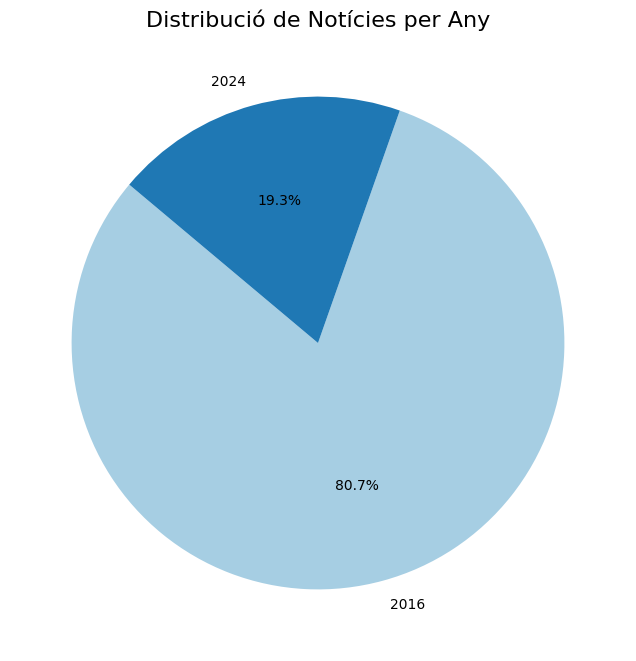

In [575]:
import matplotlib.pyplot as plt
news_by_year = df['year'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(news_by_year, labels=news_by_year.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribució de Notícies per Any", fontsize=16)
plt.show()


<Figure size 1000x600 with 0 Axes>

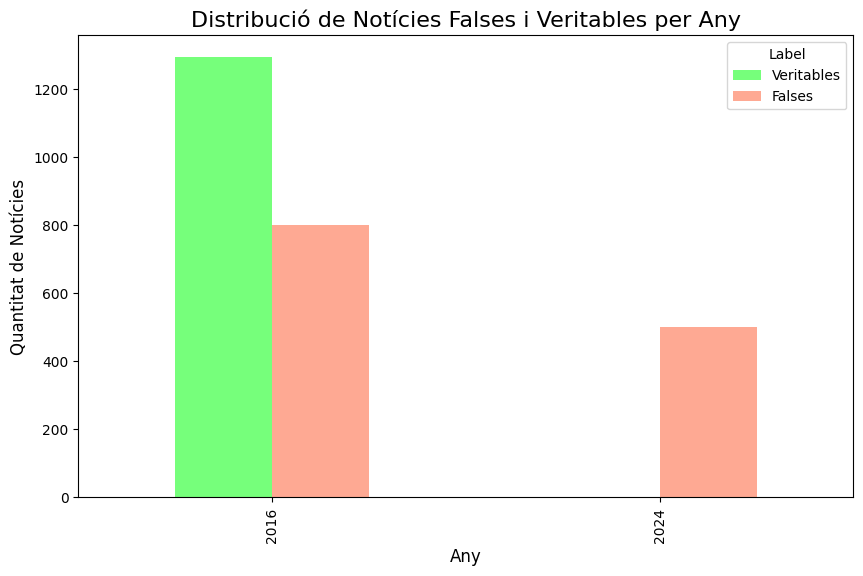

In [576]:
news_by_year_label = df.groupby(['year', 'label']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))

news_by_year_label.plot(kind='bar', stacked=False, color=['xkcd:lightgreen', 'xkcd:light salmon'], figsize=(10, 6))

plt.title("Distribució de Notícies Falses i Veritables per Any", fontsize=16)
plt.xlabel("Any", fontsize=12)
plt.ylabel("Quantitat de Notícies", fontsize=12)

plt.legend(title="Label", labels=["Veritables", "Falses"])
plt.show()


In [577]:
#canviem a Nans els noms que no tenen sentit
#df['author'] = df['author'].replace(['No Author', '-NO AUTHOR-'], np.nan)
df['main_img_url'] = df['main_img_url'].replace(['No Image URL'], np.nan)
df['title'] = df['title'].replace(['no title', '[Removed]'], np.nan)
df['text'] = df['text'].replace(['[Removed]'], np.nan)
df['text_without_stopwords'] = df['text_without_stopwords'].replace(['[ Removed ]'], np.nan)
df['title_without_stopwords'] = df['title_without_stopwords'].replace(['title', 'nan'], np.nan)

In [578]:
df.describe(include='all')

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage,year
count,2529,2594,2389,2529,2593,2593,2085,2593,2593,2405,2525,2593.000000,2594.000000
unique,805,NaN,2200,2353,5,499,1606,9,2,2197,2349,NaN,NaN
top,No Author,NaN,newsticker,“There are a lot of blogs and news sites claim...,english,prisonplanet.com,http://conservativeangle.com/wp-content/upload...,bs,Real,[ Removed ],“ lot blogs news sites claiming understand pol...,NaN,NaN
freq,505,NaN,11,9,2516,100,58,600,1300,19,9,NaN,NaN
mean,NaN,2018-05-22 07:08:40.243757056+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.803702,2017.542020
min,NaN,2016-10-26 00:51:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2016.000000
25%,NaN,2016-10-27 21:03:15+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2016.000000
50%,NaN,2016-11-01 22:13:02.201499904+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2016.000000
75%,NaN,2016-11-18 18:10:28.578500096+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2016.000000
max,NaN,2024-11-14 23:59:28+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2024.000000


In [579]:
#Mirem si hi ha nans (%)
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

['author', 'title', 'text', 'language', 'site_url', 'main_img_url', 'type', 'label', 'title_without_stopwords', 'text_without_stopwords', 'hasImage']
author                      2.505783
title                       7.902853
text                        2.505783
language                    0.038551
site_url                    0.038551
main_img_url               19.622205
type                        0.038551
label                       0.038551
title_without_stopwords     7.286045
text_without_stopwords      2.659985
hasImage                    0.038551
dtype: float64


In [580]:
#nans(#)
print(df.isnull().sum())

author                      65
published                    0
title                      205
text                        65
language                     1
site_url                     1
main_img_url               509
type                         1
label                        1
title_without_stopwords    189
text_without_stopwords      69
hasImage                     1
year                         0
dtype: int64


In [581]:
#Convertim Real a 0 i Fake a 1 i eliminem la fila que te un Nan a la columna label
df = df.dropna(subset=['label'])

df.loc[:, 'label'] = df['label'].map({'Real': 0, 'Fake': 1})
df['label'] = df['label'].astype(int)

print(df['label'].head())
print(df['label'].unique())

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64
[0 1]


In [582]:
print(df.isnull().sum())

author                      65
published                    0
title                      205
text                        64
language                     0
site_url                     0
main_img_url               508
type                         0
label                        0
title_without_stopwords    188
text_without_stopwords      68
hasImage                     0
year                         0
dtype: int64


    Eliminem la columna del url de les imatges ja que estan en un format que no es pot obrir i, per tant, no en podem fer cap anàlisi ni aprofitar-les pr a res. També eliminem les files de les notícies que no tenen text.

In [583]:
df = df.drop(columns=['main_img_url'])
"""df = df.drop(columns=['hasImage'])"""
df = df.dropna(subset=['text'])

In [584]:
print(df.isnull().sum())

author                      46
published                    0
title                      186
text                         0
language                     0
site_url                     0
type                         0
label                        0
title_without_stopwords    187
text_without_stopwords       4
hasImage                     0
year                         0
dtype: int64


Veiem que ja no queden files amb Nans a text però si a text_without_stopwords, així que mirem quines són i quin text tenen assignat. Després, utilitzem aquest text per omplir els Nans de 'text_without_stopwords'.

In [585]:
nan_texts = df[df['text_without_stopwords'].isna()]

print("Files on 'text_without_stopwords' és NaN:")
for index, row in nan_texts.iterrows():
    print(f"Índex: {index}, text_without_stopwords: {row['text_without_stopwords']}")

Files on 'text_without_stopwords' és NaN:
Índex: 2046, text_without_stopwords: nan
Índex: 2047, text_without_stopwords: nan
Índex: 2048, text_without_stopwords: nan
Índex: 2049, text_without_stopwords: nan


In [586]:
# Filtrar les files on 'text_without_stopwords' és NaN
nan_texts = df[df['text_without_stopwords'].isna()]

print("Text de les notícies amb 'text_without_stopwords' com NaN:")
for index, row in nan_texts.iterrows():
    print(f"Índex: {index}, Text: {row['text']}")

Text de les notícies amb 'text_without_stopwords' com NaN:
Índex: 2046, Text: good samaritan wearing indian headdress disarms gunman just trying to go get some weed  and saw someone who could use help published  mins ago 
portland mercury the citys tv news crews were abuzz last night with news that a young man in a native american headdress had disarmed a gunman at the max stop near east burnside and nd 
according to cops a teen suspect was on the train when he was confronted by an adult man he knew an argument ensued and the teen wound up firing two shots on the train kgw reports the headdressdonning stranger waiting at the max stop who goes by rambo richardson overpowered the gunman took his weapon and held him down 
richardson on facebook adds to that account in a string of posts and replies richardsonwho says hes a member of the haliwasaponi tribe and hails originally from north carolinasays he was just trying to go get some weed from oregons best meds and saw someone who could use

Veiem que totes estan en anglès

In [587]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def remove_stopwords(text):
    if not isinstance(text, str):
        return ''
    words = word_tokenize(text.lower()) 
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words and word.isalnum()]
    return ' '.join(filtered_words)


nan_texts = df[df['text_without_stopwords'].isna()]

for index, row in nan_texts.iterrows():
    processed_text = remove_stopwords(row['text'])
    df.at[index, 'text_without_stopwords'] = processed_text 

print("Títols de les notícies amb text sense paraules de parada actualitzat:")
for index, row in df[df['text_without_stopwords'].isna()].iterrows():
    print(f"Índex: {index}, text_without_stopwords: {row['text_without_stopwords']}")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blancapinyol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/blancapinyol/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/blancapinyol/nltk_data...


Títols de les notícies amb text sense paraules de parada actualitzat:


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [588]:
print(df.isnull().sum())

author                      46
published                    0
title                      186
text                         0
language                     0
site_url                     0
type                         0
label                        0
title_without_stopwords    187
text_without_stopwords       0
hasImage                     0
year                         0
dtype: int64


In [589]:
nan_titles = df[df['title'].isna()]

# Mostrar els títols sense paraules de parada (de la columna 'title_without_stopwords')
print("Títols sense paraules de parada per a les files amb títol NaN:")
for index, row in nan_titles.iterrows():
    print(f"Índex: {index}, title_without_stopwords: {row['title_without_stopwords']}")


Títols sense paraules de parada per a les files amb títol NaN:
Índex: 60, title_without_stopwords: nan
Índex: 61, title_without_stopwords: nan
Índex: 62, title_without_stopwords: nan
Índex: 63, title_without_stopwords: nan
Índex: 64, title_without_stopwords: nan
Índex: 65, title_without_stopwords: nan
Índex: 66, title_without_stopwords: nan
Índex: 67, title_without_stopwords: nan
Índex: 68, title_without_stopwords: nan
Índex: 70, title_without_stopwords: nan
Índex: 71, title_without_stopwords: nan
Índex: 72, title_without_stopwords: nan
Índex: 73, title_without_stopwords: nan
Índex: 74, title_without_stopwords: nan
Índex: 75, title_without_stopwords: nan
Índex: 76, title_without_stopwords: nan
Índex: 77, title_without_stopwords: nan
Índex: 78, title_without_stopwords: nan
Índex: 80, title_without_stopwords: nan
Índex: 82, title_without_stopwords: nan
Índex: 83, title_without_stopwords: nan
Índex: 85, title_without_stopwords: nan
Índex: 87, title_without_stopwords: nan
Índex: 88, title_

In [590]:
# Filtrar les files on 'title' és NaN però 'title_without_stopwords' no és NaN
nan_titles_with_non_nan_stopwords = df[df['title'].isna() & df['title_without_stopwords'].notna()]

print("Títols sense paraules de parada per a les files amb títol NaN però text processat disponible:")
for index, row in nan_titles_with_non_nan_stopwords.iterrows():
    print(f"Índex: {index}, title_without_stopwords: {row['title_without_stopwords']}")



Títols sense paraules de parada per a les files amb títol NaN però text processat disponible:
Índex: 1678, title_without_stopwords: aig quadruples limits terrorism insurance billion
Índex: 1681, title_without_stopwords: trump warns vote flipping machines
Índex: 1696, title_without_stopwords: obsolete
Índex: 1702, title_without_stopwords: nintendo cuts fullyear sales operating profit forecasts
Índex: 1705, title_without_stopwords: eu states agree caps wholesale roaming charges
Índex: 1709, title_without_stopwords: three quarters americans oppose gun control
Índex: 1710, title_without_stopwords: wikileaks email clinton operative thinks black voters stupid
Índex: 1900, title_without_stopwords: newt gingrich defends donald trump sexual predator accusations
Índex: 1907, title_without_stopwords: money laundering scheme exposed proclinton super pacs nonprofits implicated
Índex: 1909, title_without_stopwords: years later elizabeth smart realizes kidnapping even worse parents
Índex: 1915, title

In [591]:
# Assignar els valors de 'title_without_stopwords' a 'title' per a les files seleccionades
df.loc[nan_titles_with_non_nan_stopwords.index, 'title'] = nan_titles_with_non_nan_stopwords['title_without_stopwords']

In [592]:
print(df.isnull().sum())

author                      46
published                    0
title                      171
text                         0
language                     0
site_url                     0
type                         0
label                        0
title_without_stopwords    187
text_without_stopwords       0
hasImage                     0
year                         0
dtype: int64


In [593]:
#mirem si són totes en angles
nans_title = df[df['title'].isna()]
print("Totes les notícies sense títol estan en anglès:", nans_title['language'].eq('english').all())
print(nans_title['language'])

Totes les notícies sense títol estan en anglès: True
60      english
61      english
62      english
63      english
64      english
         ...   
1976    english
1977    english
1978    english
1979    english
1980    english
Name: language, Length: 171, dtype: object


Per tal d'omplir els títols amb Nans utilitzarem la tècnica RAKE(Rapid Automatic Keyword Extraction), aquesta tècnica selecciona les paraules clau més importants del text i les combina per formar un títol. Calcula les co-ocurrències de cada paraula en frases clau i la seva freqüència en tot el text.

In [594]:
from rake_nltk import Rake

def generate_title_with_keywords(text, max_keywords=5):
    if not isinstance(text, str) or not text.strip():
        return None
    r = Rake()
    r.extract_keywords_from_text(text)
    keywords = r.get_ranked_phrases()[:max_keywords]
    return ' '.join(keywords)

nan_titles = df[df['title'].isna()]
nan_title_indices = nan_titles.index 

print("Abans d'omplir els títols:")
print(nan_titles[['title', 'text']])

df['title'] = df.apply(
    lambda row: generate_title_with_keywords(row['text'], max_keywords=5) if pd.isna(row['title']) else row['title'],
    axis=1
)

filled_titles = df.loc[nan_title_indices]

print("\nDataFrame después d'omplir els títols:")
print(filled_titles[['title', 'text']])


Abans d'omplir els títols:
     title                                               text
60     NaN  here is the problem  the usa constitution stat...
61     NaN  there is plenty of proof the machines are rigg...
62     NaN  trump has an excuse now to audit any vote with...
63     NaN  he has got to go after him  he is the one caus...
64     NaN  he has got to go after him  he is the one caus...
...    ...                                                ...
1976   NaN  federal judge charges sheriff joe with contemp...
1977   NaN  all about jesus shirt sparks school uproar leg...
1978   NaN  print \nhave you ever noticed how washington a...
1979   NaN  will it be representative government or thugoc...
1980   NaN  for those who are too young or too unwilling t...

[171 rows x 2 columns]

DataFrame después d'omplir els títols:
                                                  title   
60    regimes terrorists international narcotics tra...  \
61    scam soros expects quotlandslide popular 

In [595]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def remove_stopwords(text):
    if not isinstance(text, str):
        return ''
    words = word_tokenize(text.lower()) 
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words and word.isalnum()]
    return ' '.join(filtered_words)


nan_texts = df[df['title_without_stopwords'].isna()]

for index, row in nan_texts.iterrows():
    processed_text = remove_stopwords(row['title'])
    df.at[index, 'title_without_stopwords'] = processed_text 

print("notícies amb títol sense paraules de parada actualitzat:")
for index, row in df[df['title_without_stopwords'].isna()].iterrows():
    print(f"Índex: {index}, title_without_stopwords: {row['title_without_stopwords']}")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blancapinyol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/blancapinyol/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/blancapinyol/nltk_data...


notícies amb títol sense paraules de parada actualitzat:


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [596]:
# Assignar "no author" quan author es NaN o '-NO AUTHOR-'
df['author'] = df['author'].apply(lambda x: 'No Author' if pd.isna(x) or x == '-NO AUTHOR-' else x)

In [597]:
#Mirem descripcio general
print(df.isnull().sum())

author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
type                       0
label                      0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
year                       0
dtype: int64


Ara que ja tenim les dades arreglades, podem començar a fer un anàlisi d'aquestes.

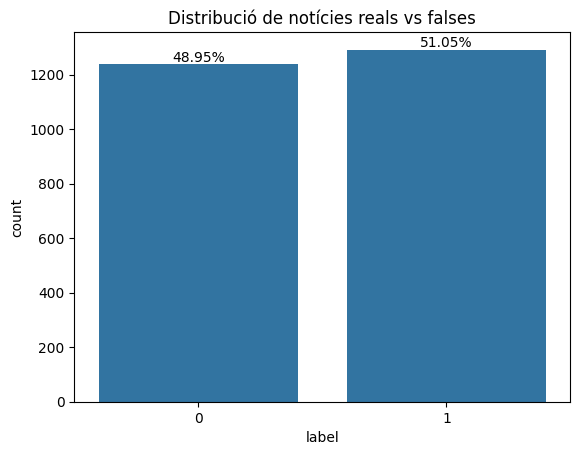

In [598]:
import seaborn as sns

label_counts = df['label'].value_counts()
label_percentages = df['label'].value_counts(normalize=True) * 100

sns.countplot(x='label', data=df)
for p in plt.gca().patches:
    height = p.get_height()
    percentage = height / len(df) * 100
    plt.text(p.get_x() + p.get_width() / 2, height + 10, f'{percentage:.2f}%', ha='center')

plt.title("Distribució de notícies reals vs falses")
plt.show()

L'objectiu de balancejar el dataset s'ha assolit satisfactoriament

Anem a veure el diferents tipus de notícies que hi ha.

Text(0.5, 1.0, 'Tipus de Notícies')

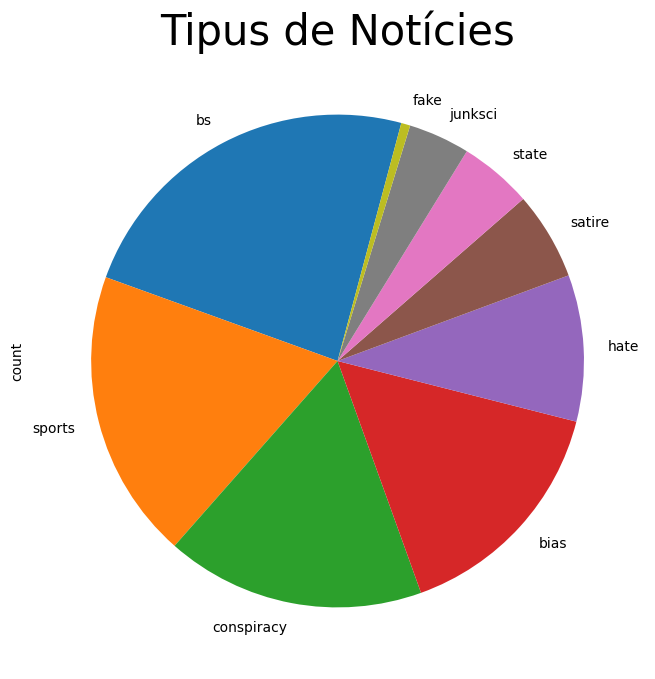

In [599]:
df['type'].value_counts().plot.pie(figsize=(10,8), startangle=75)

plt.title('Tipus de Notícies', fontsize=30)

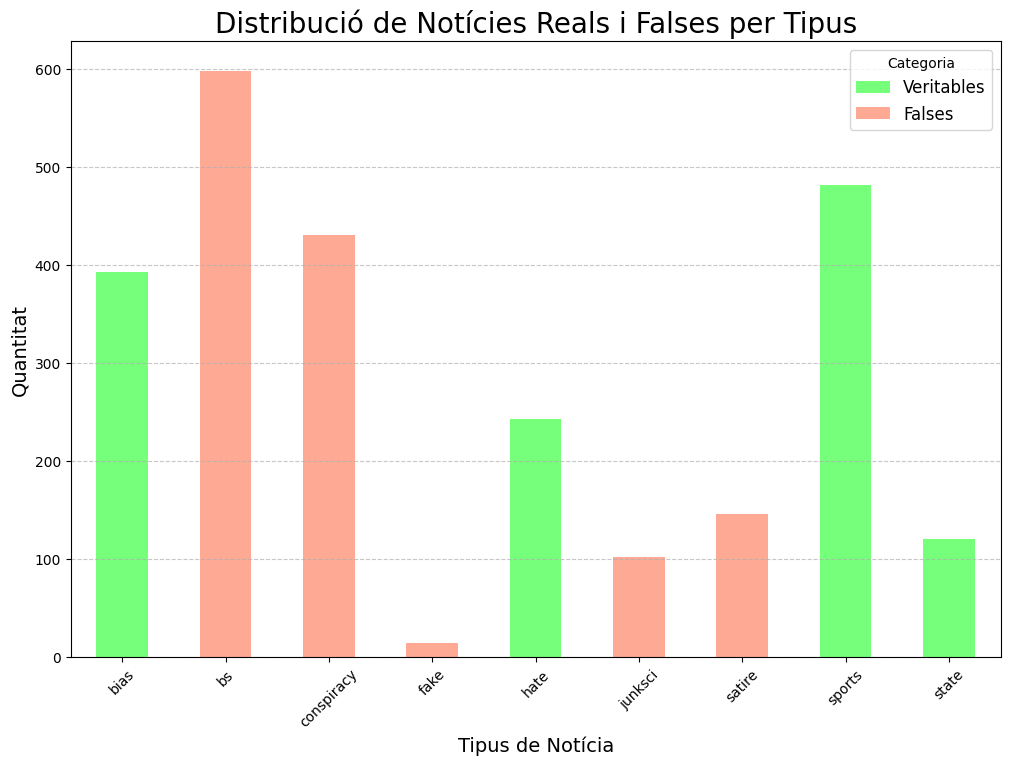

In [600]:
taula = pd.crosstab(df['type'], df['label'])

taula.plot(kind='bar', stacked=True, figsize=(12, 8), color=['xkcd:lightgreen', 'xkcd:light salmon'])

plt.title('Distribució de Notícies Reals i Falses per Tipus', fontsize=20)
plt.xlabel('Tipus de Notícia', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.legend(['Veritables', 'Falses'], title='Categoria', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [601]:
unique_languages = df['language'].unique()

print("Opcions de llengües disponibles:")
for lang in unique_languages:
    print(lang)

Opcions de llengües disponibles:
english
ignore
german
french
spanish


In [602]:
#mirem quin idioma és 'ignore'
ignored_titles = df[df['language'] == 'ignore']['title']
print("Títols de les notícies amb idioma 'ignore':")
for title in ignored_titles:
    print(title)
#
ignored_titles = df[(df['text'].isna())]['title']
print("Títols de les notícies amb idioma 'ignore':")
for title in ignored_titles:
    print(title)

Títols de les notícies amb idioma 'ignore':
billion dollars for the jewish lobby just the tip of the iceberg
national bugle radio the first step towards overthrowing jewish power
Títols de les notícies amb idioma 'ignore':


In [603]:
#veiem que és 'english' així que ho susbtituim
df['language'] = df['language'].replace('ignore', 'english').fillna('english')

In [604]:
non_english_news = df[df['language'].str.lower() != 'english']
print(non_english_news[['title', 'text', 'language']])

                                                  title   
936      sparks fly as bikers for trump meet protesters  \
937         studie beweist indianer kennen doch schmerz   
938   weil sie sich prügelten gefängnisdirektor erte...   
939   umfrage ceta würde enorm an zustimmung gewinne...   
940                                          newsticker   
...                                                 ...   
1006  sicher trainieren beim spinning gilt ab sofort...   
1007  studie lohnzahlungen verursachen milliardensch...   
1499   presstvhezbollah shares aouns victory lebanon fm   
1878  is alex jones covering for trumps jewish mob t...   
1879                  time for fbi director comey to go   

                                                   text language  
936   umfrage ceta würde enorm an zustimmung gewinne...   german  
937   steht ganz neben sich klonforscher nach erfolg...   german  
938   morgen neu am kiosk postillon am sonntag  auße...   german  
939   samstag  oktober 

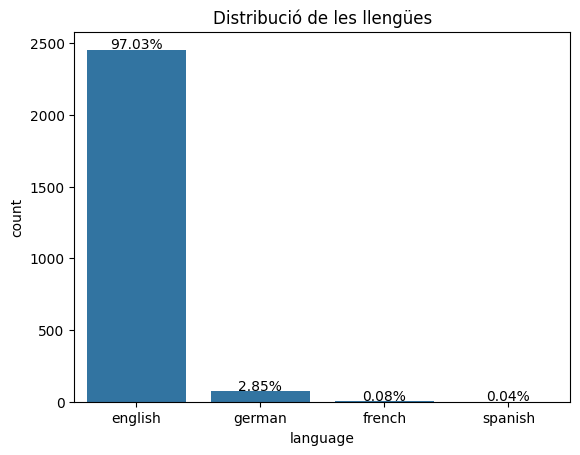

In [605]:
# Distribució dels idiomes
language_counts = df['language'].value_counts()
language_percentages = df['language'].value_counts(normalize=True) * 100

sns.countplot(x='language', data=df)
for p in plt.gca().patches:
    height = p.get_height()
    percentage = height / len(df) * 100
    plt.text(p.get_x() + p.get_width() / 2, height + 10, f'{percentage:.2f}%', ha='center')

plt.title("Distribució de les llengües")
plt.show()

Com no totes les notícies estan en el mateix idioma, aquelles que no estan en anglés les traduïm.

In [606]:
#mirem quines no estan en anglés
non_english_news = df[df['language'].str.lower() != 'english']
print(non_english_news[['title', 'text', 'language']])

                                                  title   
936      sparks fly as bikers for trump meet protesters  \
937         studie beweist indianer kennen doch schmerz   
938   weil sie sich prügelten gefängnisdirektor erte...   
939   umfrage ceta würde enorm an zustimmung gewinne...   
940                                          newsticker   
...                                                 ...   
1006  sicher trainieren beim spinning gilt ab sofort...   
1007  studie lohnzahlungen verursachen milliardensch...   
1499   presstvhezbollah shares aouns victory lebanon fm   
1878  is alex jones covering for trumps jewish mob t...   
1879                  time for fbi director comey to go   

                                                   text language  
936   umfrage ceta würde enorm an zustimmung gewinne...   german  
937   steht ganz neben sich klonforscher nach erfolg...   german  
938   morgen neu am kiosk postillon am sonntag  auße...   german  
939   samstag  oktober 

En el output anterior podem veure com hi ha notícies etiquetades en un idioma que no és el real.
Per tant, abans de traduir-les, anem a detectar el seu idioma corresponent.

In [607]:
from langdetect import detect

detected_languages = []
for index, row in df.iterrows():
    if row['language'].lower() != 'english':  
        detected_language = detect(row['text']) 
        detected_languages.append(detected_language)  
    else:
        detected_languages.append(None)  

#creem columna amb l'idioma detectat
df['detected_language'] = detected_languages
print(df[['text', 'language', 'detected_language']].dropna())

#subtituim els valor de la columna lenguage pel detectat.
df['language'] = df.apply(lambda row: row['detected_language'] if row['detected_language'] is not None else row['language'], axis=1)
df['language'] = df['language'].apply(lambda x: 'english' if x == 'en' else x)

#eliminem la columna creada anteriorment
df.drop(columns=['detected_language'], inplace=True)

print(df[['text', 'language']].head())


                                                   text language   
936   umfrage ceta würde enorm an zustimmung gewinne...   german  \
937   steht ganz neben sich klonforscher nach erfolg...   german   
938   morgen neu am kiosk postillon am sonntag  auße...   german   
939   samstag  oktober  autofahrer entlarvt geheimen...   german   
940   freitag  oktober  alle machen jagd auf ihn hor...   german   
...                                                 ...      ...   
1006  posted on october   by admin \nby vekar \none ...   german   
1007  published on may   by cbs sunday morning there...   german   
1499  the energy minister of iran hamid chitchian \n...   french   
1878      lying arrogant muslim marxist piece of dogsht   french   
1879  has anyone noticed how earnest mr earnest beco...  spanish   

     detected_language  
936                 de  
937                 de  
938                 de  
939                 de  
940                 de  
...                ...  
1006    

Hem vist que hi ha dues files que no es poden traduir, per tant les eliminem.

In [608]:
row1 = df[df['text'].str.contains('vorhaben', case=False, na=False)]
row2 = df[df['text_without_stopwords'].str.contains('vorhaben', case=False, na=False)]

print(row1)
print(row2)

                                  author                        published   
974  noreply@blogger.com (Der Postillon) 2016-11-09 16:25:14.353000+00:00  \

                                                 title   
974  donald willst du mich heiraten clinton hat kam...  \

                                                  text language   
974  donnerstag  november   radikale vorhaben die d...       de  \

              site_url type  label   
974  der-postillon.com   bs      1  \

                               title_without_stopwords   
974  offizieller friseur des weißen hauses erlitt w...  \

                                text_without_stopwords  hasImage  year  
974  freitag november musik statt lärm erster laubb...       1.0  2016  
                                  author                        published   
972  noreply@blogger.com (Der Postillon) 2016-11-09 11:48:46.757000+00:00  \

                                                 title   
972  so ein ärger obama hat über nacht s

In [609]:
df = df.drop(972)
df = df.drop(974)

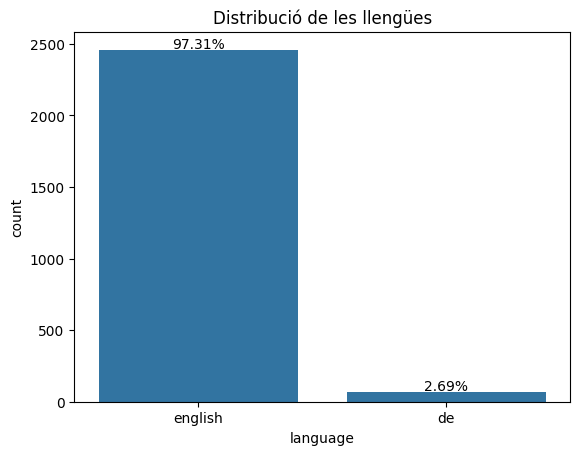

In [610]:
#mirem en quin altre idioma estan les notícies
language_counts = df['language'].value_counts()
language_percentages = df['language'].value_counts(normalize=True) * 100

sns.countplot(x='language', data=df)
for p in plt.gca().patches:
    height = p.get_height()
    percentage = height / len(df) * 100
    plt.text(p.get_x() + p.get_width() / 2, height + 10, f'{percentage:.2f}%', ha='center')

plt.title("Distribució de les llengües")
plt.show()

Ara traduïm a l'anglés les notícies que queden en alemany

In [611]:
from deep_translator import GoogleTranslator

# traductor per a anglès
traductor = GoogleTranslator(source='auto', target='en')

for index, row in df.iterrows():
    if row['language'].lower() != 'english': 
        translated_title = traductor.translate(row['title'])
        translated_text = traductor.translate(row['text'])
        translated_title_without_stopwords = traductor.translate(row['title_without_stopwords'])
        translated_text_without_stopwords = traductor.translate(row['text_without_stopwords'])
        
        # Actualizem valors
        df.at[index, 'title'] = translated_title
        df.at[index, 'text'] = translated_text
        df.at[index, 'title_without_stopwords'] = translated_title_without_stopwords
        df.at[index, 'text_without_stopwords'] = translated_text_without_stopwords


Un cop traduides, canviem la columna lenguage, d'alemany a anglés.

In [612]:
df_german = df[df['language'] == 'de']
print(df_german[['title', 'text', 'title_without_stopwords', 'text_without_stopwords', 'language']].head())

                                                 title   
936     sparks fly as bikers for trump meet protesters  \
937                  study proves Indians do know pain   
938  because they fought, prison director issues li...   
939  survey ceta would gain enormous support if eu ...   
940                                         newsticker   

                                                  text   
936  Survey CETA would gain enormous approval if th...  \
937  stands completely beside himself clone researc...   
938  tomorrow new at the kiosk postillon on sunday ...   
939  Saturday October Driver reveals secret number ...   
940  Friday October everyone is hunting him horror ...   

                               title_without_stopwords   
936  because they fought, prison director issues li...  \
937  survey ceta would gain enormous approval if eu...   
938                                         newsticker   
939                tomorrow new kiosk postillon Sunday   
940  driver 

In [613]:
df.loc[df['language'] == 'de', 'language'] = 'english'

Ja tenim totes les notícies en anglés. Mirem quines paraules són les mes frequents.

In [614]:
from sklearn.feature_extraction.text import CountVectorizer
def contar_paraules(corpus, n=None):
    vector = CountVectorizer().fit(corpus)
    paraules = vector.transform(corpus)
    suma_paraules = paraules.sum(axis=0)
    freq_paraules = [(word, suma_paraules[0, idx]) for word, idx in vector.vocabulary_.items()]
    freq_paraules = sorted(freq_paraules, key=lambda x: x[1], reverse=True)
    return freq_paraules[:n]

In [615]:
df.columns

Index(['author', 'published', 'title', 'text', 'language', 'site_url', 'type',
       'label', 'title_without_stopwords', 'text_without_stopwords',
       'hasImage', 'year'],
      dtype='object')

Amb el text:

In [616]:
paraules= contar_paraules(df['text_without_stopwords'], 20)
paraules

[('trump', 3416),
 ('clinton', 3052),
 ('one', 2429),
 ('us', 2415),
 ('said', 2356),
 ('people', 2309),
 ('would', 2239),
 ('hillary', 2045),
 ('also', 1787),
 ('like', 1706),
 ('new', 1534),
 ('election', 1503),
 ('time', 1429),
 ('even', 1406),
 ('president', 1287),
 ('state', 1256),
 ('could', 1177),
 ('get', 1176),
 ('campaign', 1144),
 ('donald', 1137)]

<Axes: xlabel='word'>

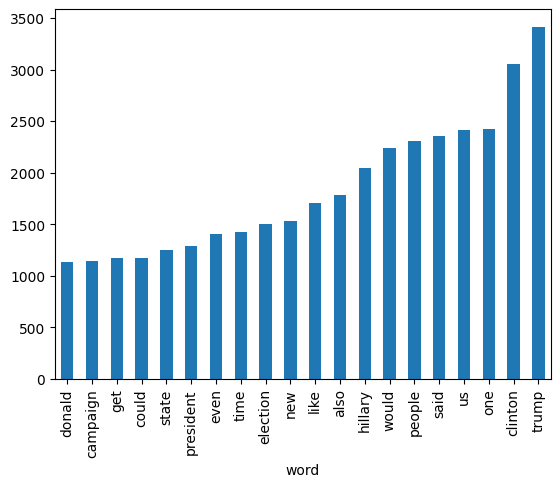

In [617]:
df1=pd.DataFrame(paraules, columns=['word', 'count'])

df1.groupby('word').sum()['count'].sort_values().plot(kind='bar')

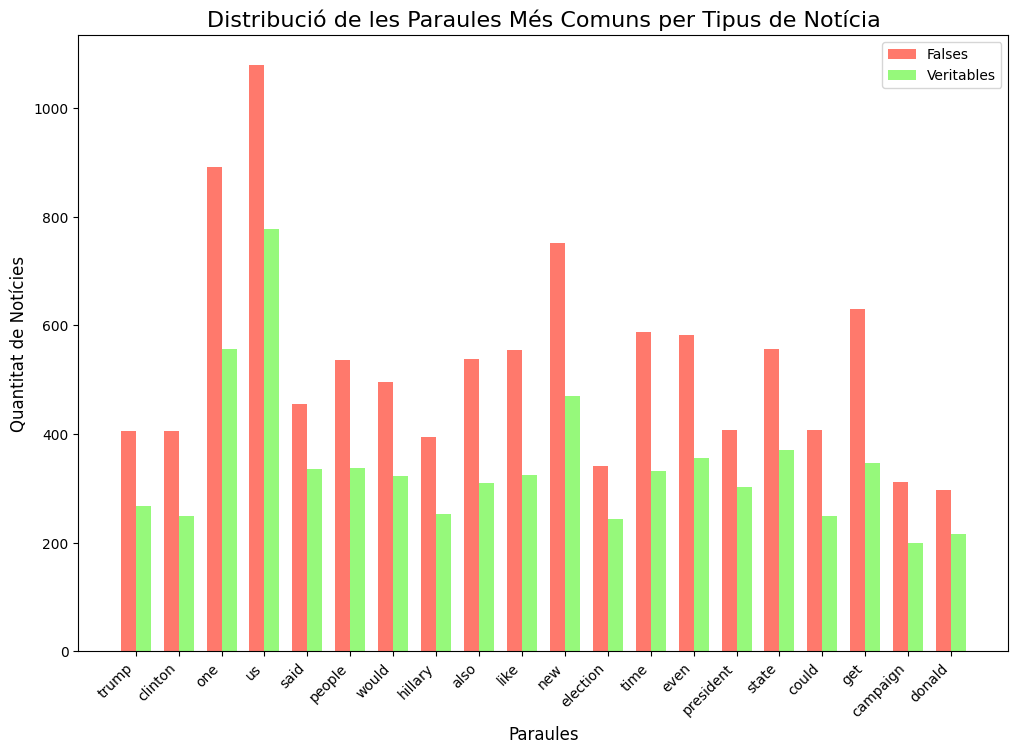

In [618]:
#diccionari per a emmagatzemar les quantitats de notícies falses i verdaderes per paraula
paraules = contar_paraules(df['text_without_stopwords'], 20)
paraules_label = {"veritables": [], "falses": []}

for word, _ in paraules:
    veritable_count = df[df['text_without_stopwords'].str.contains(word) & (df['label'] == 0)].shape[0]
    falsa_count = df[df['text_without_stopwords'].str.contains(word) & (df['label'] == 1)].shape[0]
    paraules_label["veritables"].append(veritable_count)
    paraules_label["falses"].append(falsa_count)

fig, ax = plt.subplots(figsize=(12, 8))

index = range(len(paraules))
bar_width = 0.35

bar1 = ax.bar(index, paraules_label["falses"], bar_width, label="Falses", color='xkcd:salmon')
bar2 = ax.bar([i + bar_width for i in index], paraules_label["veritables"], bar_width, label="Veritables", color='xkcd:light green')

ax.set_xlabel("Paraules", fontsize=12)
ax.set_ylabel("Quantitat de Notícies", fontsize=12)
ax.set_title("Distribució de les Paraules Més Comuns per Tipus de Notícia", fontsize=16)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels([word for word, _ in paraules], rotation=45, ha='right', fontsize=10)

ax.legend()
plt.show()

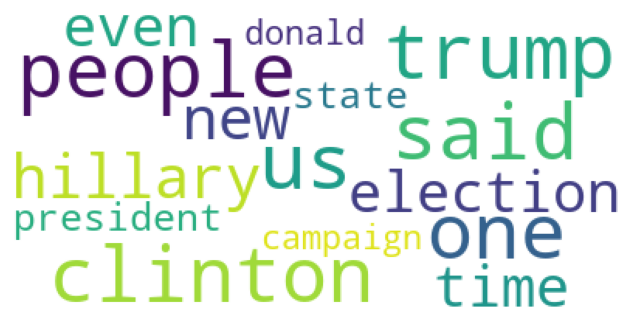

In [619]:
from wordcloud import WordCloud
text= " ".join([palabra for palabra, _ in paraules])

nuv_paraules=WordCloud(max_font_size=50, max_words=20, background_color="white").generate(text)

plt.figure(figsize=[8,8])
plt.imshow(nuv_paraules,interpolation=None)
plt.axis("off")
plt.show()

Amb el títol:


<Axes: xlabel='word'>

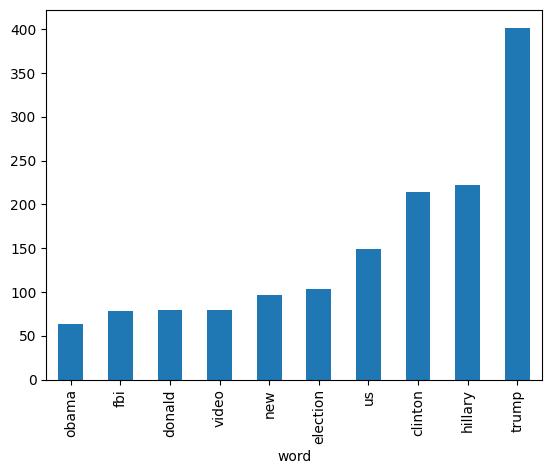

In [620]:
paraules= contar_paraules(df['title_without_stopwords'], 10)

df1=pd.DataFrame(paraules, columns=['word', 'count'])

df1.groupby('word').sum()['count'].sort_values().plot(kind='bar')

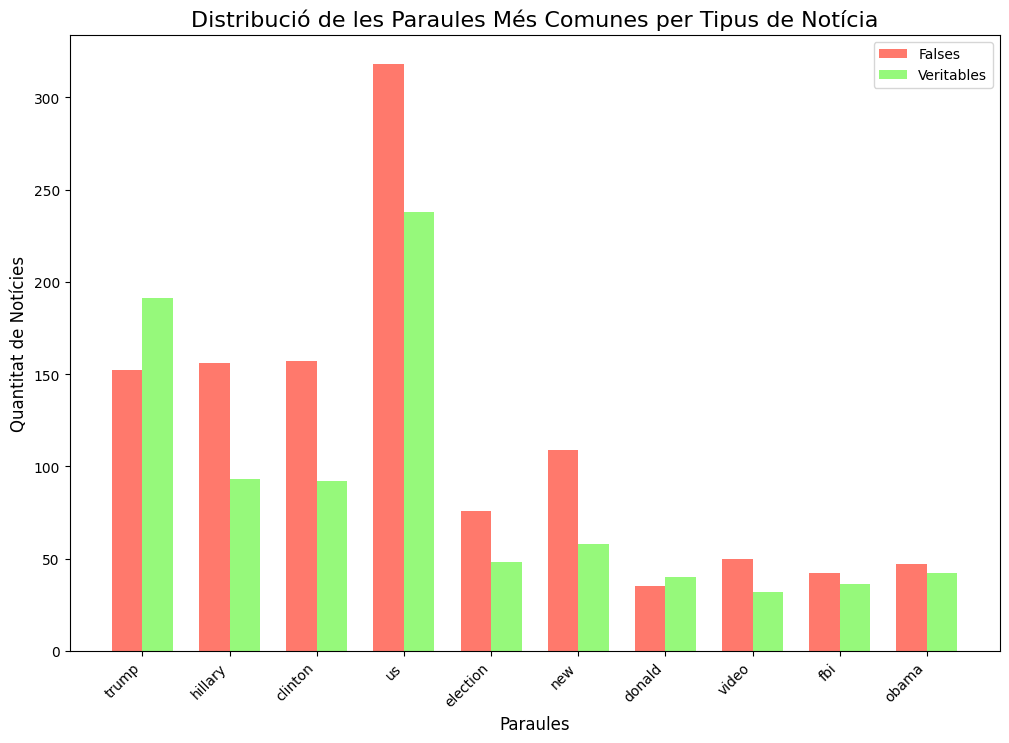

In [621]:
#diccionari amb les quantitats de notícies falses i verdaderes per paraula
paraules = contar_paraules(df['title_without_stopwords'], 10)
paraules_label = {"veritables": [], "falses": []}

for word, _ in paraules:
    veritable_count = df[df['title_without_stopwords'].str.contains(word) & (df['label'] == 0)].shape[0]
    falsa_count = df[df['title_without_stopwords'].str.contains(word) & (df['label'] == 1)].shape[0]
    paraules_label["veritables"].append(veritable_count)
    paraules_label["falses"].append(falsa_count)


fig, ax = plt.subplots(figsize=(12, 8))

index = range(len(paraules))
bar_width = 0.35

bar1 = ax.bar(index, paraules_label["falses"], bar_width, label="Falses", color='xkcd:salmon')
bar2 = ax.bar([i + bar_width for i in index], paraules_label["veritables"], bar_width, label="Veritables", color='xkcd:light green')

ax.set_xlabel("Paraules", fontsize=12)
ax.set_ylabel("Quantitat de Notícies", fontsize=12)
ax.set_title("Distribució de les Paraules Més Comunes per Tipus de Notícia", fontsize=16)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels([word for word, _ in paraules], rotation=45, ha='right', fontsize=10)

ax.legend()
plt.show()

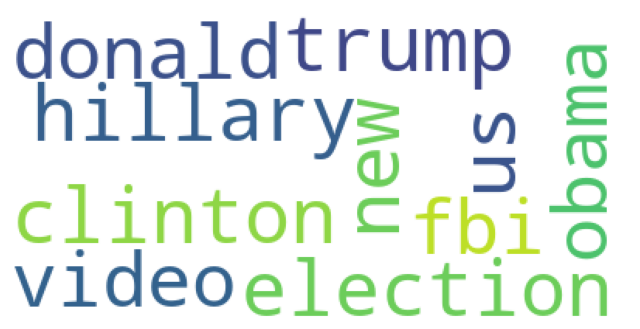

In [622]:
text= " ".join([palabra for palabra, _ in paraules])

nuv_paraules=WordCloud(max_font_size=50, max_words=10, background_color="white").generate(text)

plt.figure(figsize=[8,8])
plt.imshow(nuv_paraules,interpolation=None)
plt.axis("off")
plt.show()

Fem servir el f1-score ja que volem controlar tan els falsos positius com els falsos negatius.

Per evaluar el rendiment global del model utilitzarem la corba ROC, ja que el dataset està equilibrat.


In [623]:
# Comptar la quantitat de 0 i 1 a la columna hasImage
print(df['hasImage'].value_counts())

hasImage
1.0    2038
0.0     489
Name: count, dtype: int64


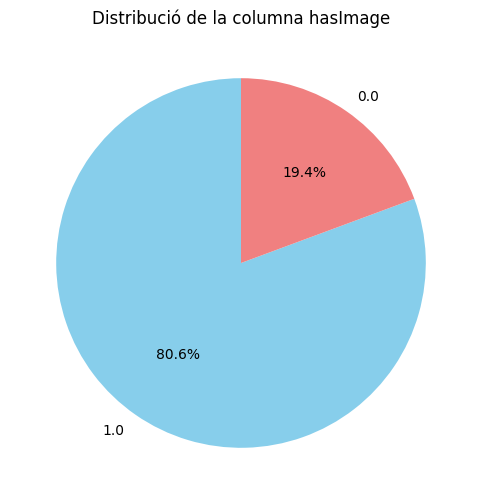

In [624]:
valors = df['hasImage'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    valors, 
    labels=valors.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue', 'lightcoral']
)

plt.title('Distribució de la columna hasImage')
plt.show()

In [625]:
# Comptar les ocurrències de cada autor
author_counts = df['author'].value_counts()
print(author_counts.head(20))


author
No Author                              575
Activist Post                           84
EdJenner                                73
noreply@blogger.com (Der Postillon)     70
Anonymous                               58
Daniel Greenfield                       55
admin                                   48
Jason Easley                            45
Alex Ansary                             44
Dr. Patrick Slattery                    38
Henry Wolff                             33
Corbett                                 27
tokyowashi (noreply@blogger.com)        20
Mike Rivero                             17
Sarah Jones                             16
Steve Watson                            16
Roosh Valizadeh                         15
Hrafnkell Haraldsson                    15
Letsbereal                              13
ActivistPost                            12
Name: count, dtype: int64


In [626]:
df['author'] = df['author'].replace(['ActivistPost'], ['Activist Post'])

In [627]:
# Comptar les ocurrències de cada autor
author_counts = df['author'].value_counts()
print(author_counts.head(20))

author
No Author                              575
Activist Post                           96
EdJenner                                73
noreply@blogger.com (Der Postillon)     70
Anonymous                               58
Daniel Greenfield                       55
admin                                   48
Jason Easley                            45
Alex Ansary                             44
Dr. Patrick Slattery                    38
Henry Wolff                             33
Corbett                                 27
tokyowashi (noreply@blogger.com)        20
Mike Rivero                             17
Sarah Jones                             16
Steve Watson                            16
Roosh Valizadeh                         15
Hrafnkell Haraldsson                    15
Letsbereal                              13
Fed Up                                  12
Name: count, dtype: int64


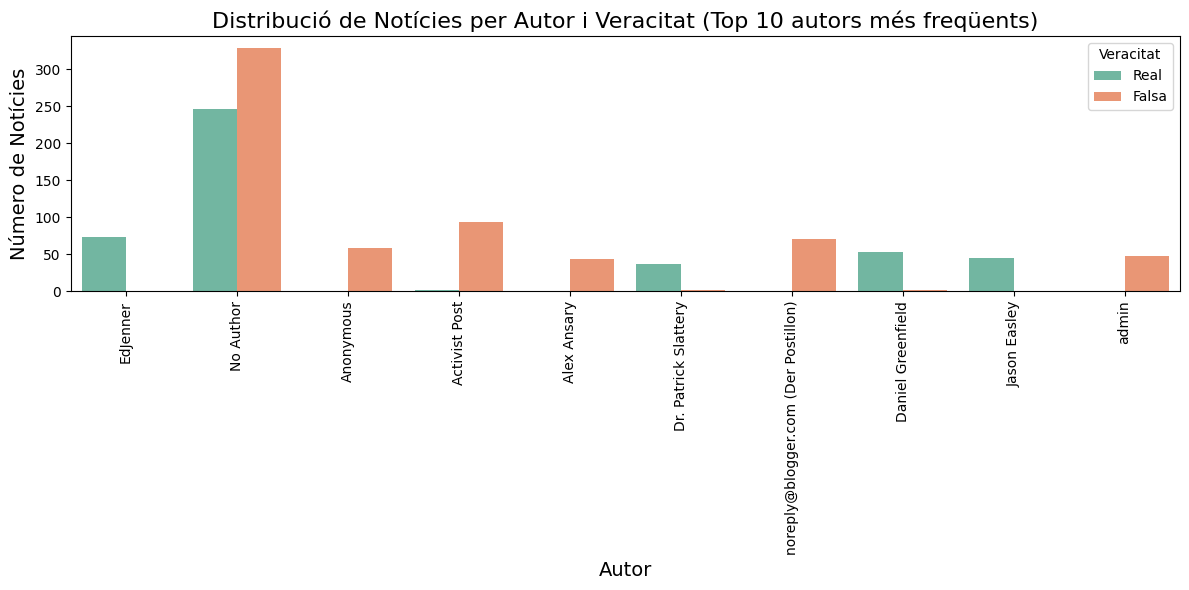

In [628]:
# autors més freqüents
top_authors = df['author'].value_counts().head(10).index  

df_top_authors = df[df['author'].isin(top_authors)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_top_authors, x='author', hue='label', palette='Set2')

plt.title("Distribució de Notícies per Autor i Veracitat (Top 10 autors més freqüents)", fontsize=16)
plt.xlabel("Autor", fontsize=14)
plt.ylabel("Número de Notícies", fontsize=14)


plt.xticks(rotation=90) 
plt.legend(title='Veracitat', labels=['Real', 'Falsa'])
plt.tight_layout()  
plt.show()




La data de publicacio i el site_url els eliminem.

Com totes les noticies ara estan en anglés, no ens cal la columna lenguage.

La columna type no conté informació realista, per tant, l'eliminem. 

Les columnes title i text ja no ens fan falta pq tenim la seva versió without stopwords.


In [629]:
df = df.drop(['published','site_url', 'language', 'type', 'title', 'text'], axis=1)


El que farem primer serà entrar per diferents models amb només el text without stopwords com a X, farem cross validation i cerca d'hiperparàmetres. 

Després farem el mateix només amb title without stopwords.

Tornem a fer el mateix procediment, però afegint si té imatge o no, per veure si millora. També mirem si millora o no amb l'autor.

Provem tot amb el mètode Bow i TF-IDF

# BAG OF WORDS

**TEXT**

CROSS-VALIDATION

In [630]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Bag of words
bow_vectorizer = CountVectorizer(max_features=5000)  
X_bow = bow_vectorizer.fit_transform(df['text_without_stopwords'])  

y = df['label']  
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_bow, y, test_size=0.2, random_state=42)


In [631]:
y.mean(),y_test1.mean(),y_train1.mean() #si està estratificat

(0.5100910170162247, 0.5296442687747036, 0.5051954477981198)

In [632]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
cv_scoresNB = cross_val_score(nb, X_train1, y_train1, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes:", cv_scoresNB.mean())

Naive Bayes: 0.6910526279481888


In [633]:
from sklearn.naive_bayes import GaussianNB

nb_gaussian = GaussianNB()
cv_scores_gaussian = cross_val_score(nb_gaussian, X_train1.toarray(), y_train1, cv=StratifiedKFold(n_splits = 5), scoring='f1') 
print("GaussianNB:", cv_scores_gaussian.mean())

GaussianNB: 0.6197598299618388


In [634]:
from sklearn.naive_bayes import BernoulliNB

nb_bernoulli = BernoulliNB()
cv_scores_bernoulli = cross_val_score(nb_bernoulli, X_train1, y_train1, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("BernoulliNB:", cv_scores_bernoulli.mean())


BernoulliNB: 0.5969812678857692


In [635]:
from sklearn.naive_bayes import ComplementNB

nb_complement = ComplementNB()
cv_scores_complement = cross_val_score(nb_complement, X_train1, y_train1, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("ComplementNB:", cv_scores_complement.mean())


ComplementNB: 0.6900429564117332


CERCA D'HIPERPARÀMETRES

In [636]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from sklearn.metrics import classification_report

def grid_search_nb(model, param_grid, X, y, model_name):
    grid = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits = 5), scoring='f1', n_jobs=-1)
    grid.fit(X, y)
    print(f"--- {model_name} ---")
    print("Millors hiperparàmetres:", grid.best_params_)
    print("Millor F1-score:", grid.best_score_)
    return grid

# MultinomialNB
param_grid_multinomial = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_multinomial1 = grid_search_nb(MultinomialNB(), param_grid_multinomial, X_train1, y_train1, "MultinomialNB")

# ComplementNB
param_grid_complement = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'norm': [True, False]}
grid_complement1 = grid_search_nb(ComplementNB(), param_grid_complement, X_train1, y_train1, "ComplementNB")



--- MultinomialNB ---
Millors hiperparàmetres: {'alpha': 0.01}
Millor F1-score: 0.7172818716174544
--- ComplementNB ---
Millors hiperparàmetres: {'alpha': 0.01, 'norm': False}
Millor F1-score: 0.7164185397051136


----
**TÍTOL**

In [637]:
# bag of words
bow_vectorizer = CountVectorizer(max_features=5000)  
X_bow2 = bow_vectorizer.fit_transform(df['title_without_stopwords'])  

y = df['label']  
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_bow2, y, test_size=0.2, random_state=42)

In [638]:
nb = MultinomialNB()
cv_scoresNB = cross_val_score(nb, X_train2, y_train2, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes:", cv_scoresNB.mean())

Naive Bayes: 0.7312982458368233


In [639]:
nb_gaussian = GaussianNB()
cv_scores_gaussian = cross_val_score(nb_gaussian, X_train2.toarray(), y_train2, cv=StratifiedKFold(n_splits = 5), scoring='f1') 
print("GaussianNB:", cv_scores_gaussian.mean())

GaussianNB: 0.6624589708753431


In [640]:
nb_bernoulli = BernoulliNB()
cv_scores_bernoulli = cross_val_score(nb_bernoulli, X_train2, y_train2, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("BernoulliNB:", cv_scores_bernoulli.mean())

BernoulliNB: 0.7322933497156145


In [641]:
nb_complement = ComplementNB()
cv_scores_complement = cross_val_score(nb_complement, X_train2, y_train2, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("ComplementNB:", cv_scores_complement.mean())


ComplementNB: 0.7319373660990859


CERCA D'HIPERPARÀMETRES

In [642]:
# MultinomialNB
param_grid_multinomial = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_multinomial2 = grid_search_nb(MultinomialNB(), param_grid_multinomial, X_train2, y_train2, "MultinomialNB")

# BernoulliNB
param_grid_bernoulli = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 6.0], 'binarize': [0.0, 0.5, 1.0]}
grid_bernoulli2 = grid_search_nb(BernoulliNB(), param_grid_bernoulli, X_train2, y_train2, "BernoulliNB")

# ComplementNB
param_grid_complement = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'norm': [True, False]}
grid_complement2 = grid_search_nb(ComplementNB(), param_grid_complement, X_train2, y_train2, "ComplementNB")



--- MultinomialNB ---
Millors hiperparàmetres: {'alpha': 0.5}
Millor F1-score: 0.7335256844720129
--- BernoulliNB ---
Millors hiperparàmetres: {'alpha': 5.0, 'binarize': 0.0}
Millor F1-score: 0.7395300221109358
--- ComplementNB ---
Millors hiperparàmetres: {'alpha': 2.0, 'norm': True}
Millor F1-score: 0.7371390967667508


----
**TÍTOL I HASIMAGE**


In [643]:
from scipy.sparse import hstack

# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow2 = bow_vectorizer.fit_transform(df['title_without_stopwords'])

X_image = df[['hasImage']]  
X_combined = hstack([X_bow2, X_image])  

y = df['label']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_combined, y, test_size=0.2, random_state=42)


CROSS-VALIDATION 

In [644]:
nb = MultinomialNB()
cv_scoresNB = cross_val_score(nb, X_train3, y_train3, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes:", cv_scoresNB.mean())

Naive Bayes: 0.7329574864949728


In [645]:
nb_gaussian = GaussianNB()
cv_scores_gaussian = cross_val_score(nb_gaussian, X_train3.toarray(), y_train3, cv=StratifiedKFold(n_splits = 5), scoring='f1') 
print("GaussianNB:", cv_scores_gaussian.mean())

GaussianNB: 0.6624589708753431


In [646]:
nb_bernoulli = BernoulliNB()
cv_scores_bernoulli = cross_val_score(nb_bernoulli, X_train3, y_train3, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("BernoulliNB:", cv_scores_bernoulli.mean())

BernoulliNB: 0.7342647818229107


In [647]:
nb_complement = ComplementNB()
cv_scores_complement = cross_val_score(nb_complement, X_train3, y_train3, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("ComplementNB:", cv_scores_complement.mean())

ComplementNB: 0.7308936193844567


CERCA D'HIPERPARÀMETRES

In [648]:
# MultinomialNB
param_grid_multinomial = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_multinomial3 = grid_search_nb(MultinomialNB(), param_grid_multinomial, X_train3, y_train3, "MultinomialNB")

# BernoulliNB
param_grid_bernoulli = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 6.0], 'binarize': [0.0, 0.5, 1.0]}
grid_bernoulli3 = grid_search_nb(BernoulliNB(), param_grid_bernoulli, X_train3, y_train3, "BernoulliNB")

# ComplementNB
param_grid_complement = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'norm': [True, False]}
grid_complement3 = grid_search_nb(ComplementNB(), param_grid_complement, X_train3, y_train3, "ComplementNB")



--- MultinomialNB ---
Millors hiperparàmetres: {'alpha': 0.5}
Millor F1-score: 0.7333095645322432
--- BernoulliNB ---
Millors hiperparàmetres: {'alpha': 6.0, 'binarize': 0.0}
Millor F1-score: 0.7433314745023042
--- ComplementNB ---
Millors hiperparàmetres: {'alpha': 0.5, 'norm': True}
Millor F1-score: 0.7345657742902232


----
**TEXT I HASIMAGE**

In [649]:
# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow2 = bow_vectorizer.fit_transform(df['text_without_stopwords'])

X_image = df[['hasImage']]  
X_combined = hstack([X_bow2, X_image])  

y = df['label']
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_combined, y, test_size=0.2, random_state=42)

CROSS-VALIDATION

In [650]:
nb = MultinomialNB()
cv_scoresNB = cross_val_score(nb, X_train4, y_train4, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes:", cv_scoresNB.mean())

Naive Bayes: 0.6905549023592084


In [651]:
nb_gaussian = GaussianNB()
cv_scores_gaussian = cross_val_score(nb_gaussian, X_train4.toarray(), y_train4, cv=StratifiedKFold(n_splits = 5), scoring='f1') 
print("GaussianNB:", cv_scores_gaussian.mean())

GaussianNB: 0.6197598299618388


In [652]:
nb_bernoulli = BernoulliNB()
cv_scores_bernoulli = cross_val_score(nb_bernoulli, X_train4, y_train4, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("BernoulliNB:", cv_scores_bernoulli.mean())

BernoulliNB: 0.5946079180497028


In [653]:
nb_complement = ComplementNB()
cv_scores_complement = cross_val_score(nb_complement, X_train4, y_train4, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("ComplementNB:", cv_scores_complement.mean())

ComplementNB: 0.6887534734550522


CERCA D'HIPERPARÀMETRES

In [654]:
# MultinomialNB
param_grid_multinomial = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_multinomial4 = grid_search_nb(MultinomialNB(), param_grid_multinomial, X_train4, y_train4, "MultinomialNB")

# ComplementNB
param_grid_complement = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'norm': [True, False]}
grid_complement4 = grid_search_nb(ComplementNB(), param_grid_complement, X_train4, y_train4, "ComplementNB")



--- MultinomialNB ---
Millors hiperparàmetres: {'alpha': 0.01}
Millor F1-score: 0.7161429418382997
--- ComplementNB ---
Millors hiperparàmetres: {'alpha': 0.01, 'norm': False}
Millor F1-score: 0.7151475812064781


-----
**TÍTOL I AUTOR**

In [655]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

X = df[['author', 'title_without_stopwords']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

title_vectorizer = CountVectorizer()

author_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
month_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('title', title_vectorizer, 'title_without_stopwords'),
        ('author', author_encoder, ['author']),   
    ]
)

pipeline_multinomial = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

pipeline_bernoulli = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BernoulliNB()) 
])

pipeline_complement = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ComplementNB()) 
])

In [656]:
cv_scoresNB = cross_val_score(pipeline_multinomial, X_train, y_train, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes F1-score (Cross-validation):", cv_scoresNB.mean())

Naive Bayes F1-score (Cross-validation): 0.8320623783196861


In [657]:
cv_scores_bernoulli = cross_val_score(pipeline_bernoulli, X_train, y_train, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes F1-score (Cross-validation):", cv_scores_bernoulli.mean())

Naive Bayes F1-score (Cross-validation): 0.832027779458936


In [658]:
cv_scores_complement = cross_val_score(pipeline_complement, X_train, y_train, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes F1-score (Cross-validation):", cv_scores_complement.mean())

Naive Bayes F1-score (Cross-validation): 0.8344676574427412


In [659]:
# MultinomialNB
param_grid_multinomial = {'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_multinomial = GridSearchCV(pipeline_multinomial, param_grid_multinomial, cv=StratifiedKFold(n_splits = 5), scoring='f1', n_jobs=-1)
grid_multinomial.fit(X_train, y_train)
print(f"--- MultinomialNB ---")
print("Millors hiperparàmetres:", grid_multinomial.best_params_)
print("Millor F1-score (validació creuada):", grid_multinomial.best_score_)

# ComplementNB
param_grid_complement = {'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'classifier__fit_prior': [True, False]}
grid_complement = GridSearchCV(pipeline_complement, param_grid_complement, cv=StratifiedKFold(n_splits = 5, shuffle=True,random_state=42), scoring='f1', n_jobs=-1)
grid_complement.fit(X_train, y_train)
print(f"--- ComplementlNB ---")
print("Millors hiperparàmetres:", grid_complement.best_params_)
print("Millor F1-score (validació creuada):", grid_complement.best_score_)

--- MultinomialNB ---
Millors hiperparàmetres: {'classifier__alpha': 1.0}
Millor F1-score (validació creuada): 0.8320623783196861
--- ComplementlNB ---
Millors hiperparàmetres: {'classifier__alpha': 0.5, 'classifier__fit_prior': True}
Millor F1-score (validació creuada): 0.8243104049138411


------

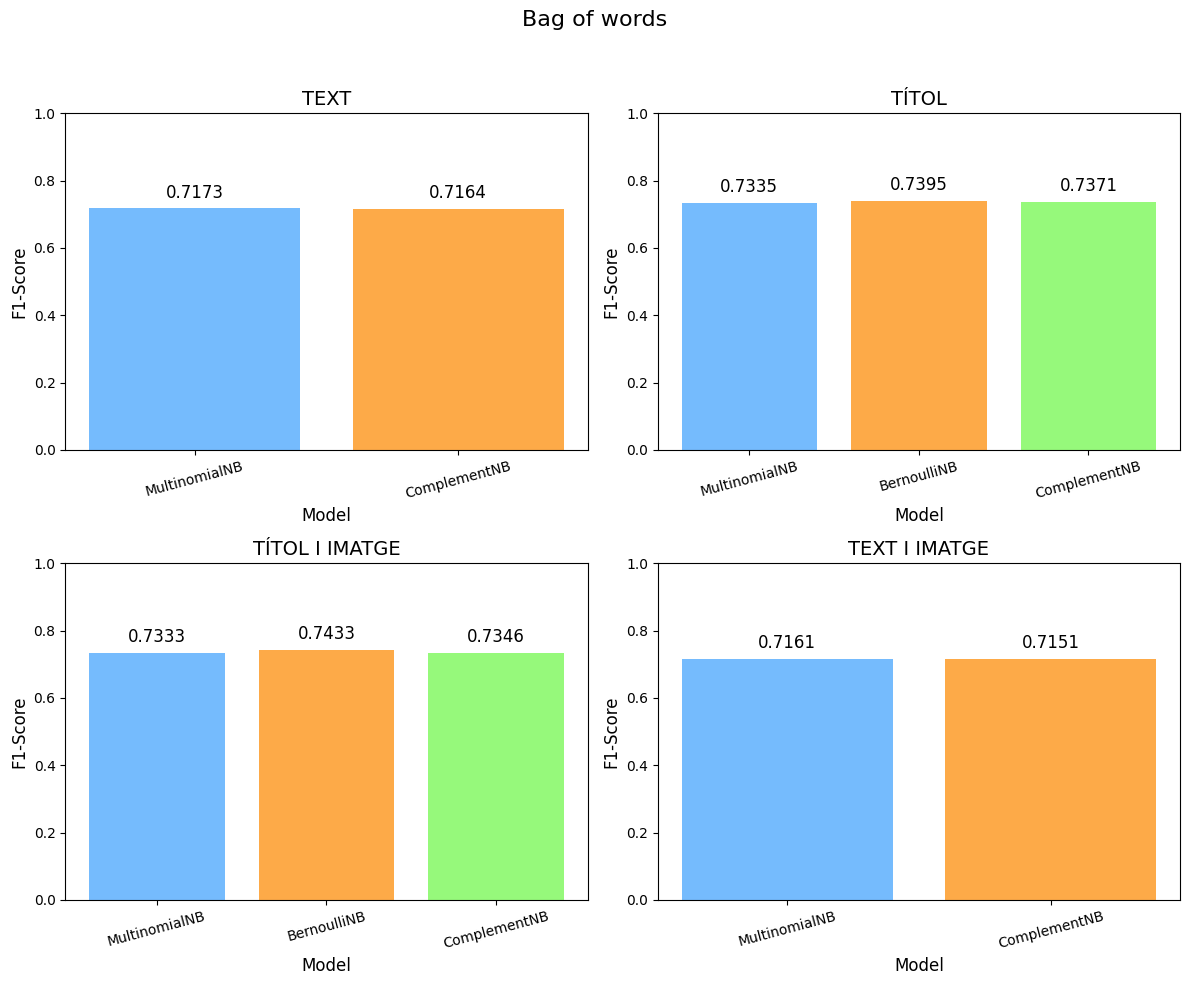

In [660]:
configs = [
    (["MultinomialNB", "ComplementNB"], [grid_multinomial1.best_score_, grid_complement1.best_score_ ], "TEXT"),
    (["MultinomialNB", "BernoulliNB","ComplementNB"], [grid_multinomial2.best_score_,grid_bernoulli2.best_score_, grid_complement2.best_score_ ], "TÍTOL"),
    (["MultinomialNB","BernoulliNB", "ComplementNB"], [grid_multinomial3.best_score_,grid_bernoulli3.best_score_, grid_complement3.best_score_ ], "TÍTOL I IMATGE"),
    (["MultinomialNB", "ComplementNB"], [grid_multinomial4.best_score_, grid_complement4.best_score_ ], "TEXT I IMATGE"),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Bag of words", fontsize=16)

for ax, (models, scores, title) in zip(axes.flatten(), configs):
    bars = ax.bar(models, scores, color=['xkcd:sky blue', 'xkcd:light orange', 'xkcd:light green', 'xkcd:salmon'][:len(models)])
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("F1-Score", fontsize=12)
    ax.tick_params(axis='x', rotation=15)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


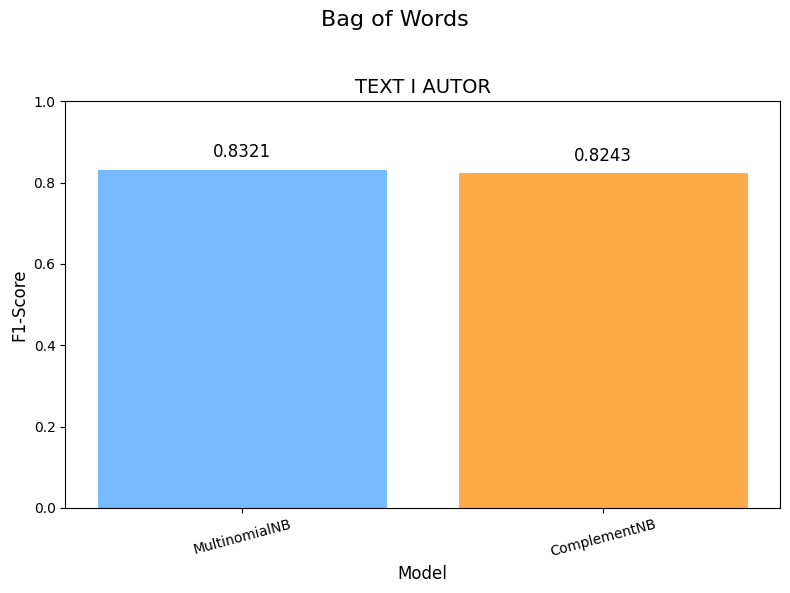

In [661]:
configs = [
    (["MultinomialNB", "ComplementNB"], [grid_multinomial.best_score_, grid_complement.best_score_], "TEXT I AUTOR"),
]

fig, axes = plt.subplots(1, 1, figsize=(8, 6))  # Un sol gràfic
fig.suptitle("Bag of Words", fontsize=16)

bars = axes.bar(configs[0][0], configs[0][1], color=['xkcd:sky blue', 'xkcd:light orange'])
axes.set_ylim(0, 1)
axes.set_title(configs[0][2], fontsize=14)
axes.set_xlabel("Model", fontsize=12)
axes.set_ylabel("F1-Score", fontsize=12)
axes.tick_params(axis='x', rotation=15)

for bar in bars:
    yval = bar.get_height()
    axes.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# TF-IDF

**TEXT**

In [662]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_without_stopwords'])

y = df['label']
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)



CROSS-VALIDATION

In [663]:
nb = MultinomialNB()
cv_scoresNB = cross_val_score(nb, X_train5, y_train5, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes:", cv_scoresNB.mean())

Naive Bayes: 0.7802485521796965


In [664]:
nb_gaussian = GaussianNB()
cv_scores_gaussian = cross_val_score(nb_gaussian, X_train5.toarray(), y_train5, cv=StratifiedKFold(n_splits = 5), scoring='f1') 
print("GaussianNB:", cv_scores_gaussian.mean())

GaussianNB: 0.7475900016158821


In [665]:
nb_bernoulli = BernoulliNB()
cv_scores_bernoulli = cross_val_score(nb_bernoulli, X_train5, y_train5, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("BernoulliNB:", cv_scores_bernoulli.mean())

BernoulliNB: 0.5969812678857692


In [666]:
nb_complement = ComplementNB()
cv_scores_complement = cross_val_score(nb_complement, X_train5, y_train5, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("ComplementNB:", cv_scores_complement.mean())

ComplementNB: 0.7752686726598316


CERCA D'HIPERPARÀMETRES

In [667]:
# MultinomialNB
param_grid_multinomial = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 7.0, 8.0, 10.0, 12.0]}
grid_multinomial5 = grid_search_nb(MultinomialNB(), param_grid_multinomial, X_train5, y_train5, "MultinomialNB")

# GaussianNB
param_grid_gaussian = {}  # GaussianNB no tiene hiperparámetros específicos
grid_gaussian5 = grid_search_nb(GaussianNB(), param_grid_gaussian, X_train5.toarray(), y_train5, "GaussianNB")

# ComplementNB
param_grid_complement = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 2.5, 5.0], 'norm': [True, False]}
grid_complement5 = grid_search_nb(ComplementNB(), param_grid_complement, X_train5, y_train5, "ComplementNB")



--- MultinomialNB ---
Millors hiperparàmetres: {'alpha': 5.0}
Millor F1-score: 0.8029099484017586
--- GaussianNB ---
Millors hiperparàmetres: {}
Millor F1-score: 0.7475900016158821
--- ComplementNB ---
Millors hiperparàmetres: {'alpha': 2.5, 'norm': True}
Millor F1-score: 0.8044735076262624


----
**TÍTOL**

In [668]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['title_without_stopwords'])

y = df['label']
X_train6, X_test6, y_train6, y_test6 = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


CROSS-VALIDATION

In [669]:
nb = MultinomialNB()
cv_scoresNB = cross_val_score(nb, X_train6, y_train6, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes:", cv_scoresNB.mean())

Naive Bayes: 0.7474893383968009


In [670]:
nb_gaussian = GaussianNB()
cv_scores_gaussian = cross_val_score(nb_gaussian, X_train6.toarray(), y_train6,cv=StratifiedKFold(n_splits = 5), scoring='f1') 
print("GaussianNB:", cv_scores_gaussian.mean())

GaussianNB: 0.6837646568696754


In [671]:
nb_bernoulli = BernoulliNB()
cv_scores_bernoulli = cross_val_score(nb_bernoulli, X_train6, y_train6, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("BernoulliNB:", cv_scores_bernoulli.mean())

BernoulliNB: 0.7322933497156145


In [672]:
nb_complement = ComplementNB()
cv_scores_complement = cross_val_score(nb_complement, X_train6, y_train6, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("ComplementNB:", cv_scores_complement.mean())

ComplementNB: 0.7415728647218554


CERCA D'HIPERPARÀMETRES

In [673]:
# MultinomialNB
param_grid_multinomial = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_multinomial6 = grid_search_nb(MultinomialNB(), param_grid_multinomial, X_train6, y_train6, "MultinomialNB")

# BernoulliNB
param_grid_bernoulli = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 6.0], 'binarize': [0.0, 0.5, 1.0]}
grid_bernoulli6 = grid_search_nb(BernoulliNB(), param_grid_bernoulli, X_train6, y_train6, "BernoulliNB")

# ComplementNB
param_grid_complement = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'norm': [True, False]}
grid_complement6 = grid_search_nb(ComplementNB(), param_grid_complement, X_train6, y_train6, "ComplementNB")



--- MultinomialNB ---
Millors hiperparàmetres: {'alpha': 1.0}
Millor F1-score: 0.7474893383968009
--- BernoulliNB ---
Millors hiperparàmetres: {'alpha': 5.0, 'binarize': 0.0}
Millor F1-score: 0.7395300221109358
--- ComplementNB ---
Millors hiperparàmetres: {'alpha': 1.0, 'norm': True}
Millor F1-score: 0.7418014394385178


----
**TEXT I HASIMAGE**

In [674]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_without_stopwords'])

X_image = df[['hasImage']]  
X_combined = hstack([X_tfidf, X_image])  

y = df['label']

X_train7, X_test7, y_train7, y_test7 = train_test_split(X_combined, y, test_size=0.2, random_state=42)

CROSS-VALIDATION

In [675]:
nb = MultinomialNB()
cv_scoresNB = cross_val_score(nb, X_train7, y_train7, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes:", cv_scoresNB.mean())

Naive Bayes: 0.7768923720291829


In [676]:
nb_gaussian = GaussianNB()
cv_scores_gaussian = cross_val_score(nb_gaussian, X_train7.toarray(), y_train7, cv=StratifiedKFold(n_splits = 5), scoring='f1') 
print("GaussianNB:", cv_scores_gaussian.mean())

GaussianNB: 0.7533517864192836


In [677]:
nb_bernoulli = BernoulliNB()
cv_scores_bernoulli = cross_val_score(nb_bernoulli, X_train7, y_train7, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("BernoulliNB:", cv_scores_bernoulli.mean())

BernoulliNB: 0.5946079180497028


In [678]:
nb_complement = ComplementNB()
cv_scores_complement = cross_val_score(nb_complement, X_train7, y_train7, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("ComplementNB:", cv_scores_complement.mean())

ComplementNB: 0.7725165790615343


CERCA D'HIPERPARÀMETRES

In [679]:
# MultinomialNB
param_grid_multinomial = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 6.0]}
grid_multinomial7 = grid_search_nb(MultinomialNB(), param_grid_multinomial, X_train7, y_train7, "MultinomialNB")

# GaussianNB
param_grid_gaussian = {}
grid_gaussian7 = grid_search_nb(GaussianNB(), param_grid_gaussian, X_train7.toarray(), y_train7, "GaussianNB")

# ComplementNB
param_grid_complement = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'norm': [True, False]}
grid_complement7 = grid_search_nb(ComplementNB(), param_grid_complement, X_train7, y_train7, "ComplementNB")



--- MultinomialNB ---
Millors hiperparàmetres: {'alpha': 6.0}
Millor F1-score: 0.7830517446825576
--- GaussianNB ---
Millors hiperparàmetres: {}
Millor F1-score: 0.7533517864192836
--- ComplementNB ---
Millors hiperparàmetres: {'alpha': 0.01, 'norm': False}
Millor F1-score: 0.7773022474467682


---
**TITOL I HASIMAGE**

Com amb el bag of words el que ens ha donat millor ha estat el titol+imatge ho provem també en aquest cas

In [680]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['title_without_stopwords'])

X_image = df[['hasImage']]  
X_combined = hstack([X_bow2, X_image])  

y = df['label']
X_train8, X_test8, y_train8, y_test8 = train_test_split(X_combined, y, test_size=0.2, random_state=42)

CROSS-VALIDATION

In [681]:
nb = MultinomialNB()
cv_scoresNB = cross_val_score(nb, X_train8, y_train8, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes:", cv_scoresNB.mean())

Naive Bayes: 0.6905549023592084


In [682]:
nb_gaussian = GaussianNB()
cv_scores_gaussian = cross_val_score(nb_gaussian, X_train8.toarray(), y_train8, cv=StratifiedKFold(n_splits = 5), scoring='f1') 
print("GaussianNB:", cv_scores_gaussian.mean())

GaussianNB: 0.6197598299618388


In [683]:
nb_bernoulli = BernoulliNB()
cv_scores_bernoulli = cross_val_score(nb_bernoulli, X_train8, y_train8, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("BernoulliNB:", cv_scores_bernoulli.mean())

BernoulliNB: 0.5946079180497028


In [684]:
nb_complement = ComplementNB()
cv_scores_complement = cross_val_score(nb_complement, X_train8, y_train8, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("ComplementNB:", cv_scores_complement.mean())

ComplementNB: 0.6887534734550522


CERCA D'HIPERPARÀMETRES

In [685]:
# MultinomialNB
param_grid_multinomial = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 6.0]}
grid_multinomial8 = grid_search_nb(MultinomialNB(), param_grid_multinomial, X_train8, y_train8, "MultinomialNB")

# GaussianNB
param_grid_gaussian = {} 
grid_gaussian8 = grid_search_nb(GaussianNB(), param_grid_gaussian, X_train8.toarray(), y_train8, "GaussianNB")

# ComplementNB
param_grid_complement = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'norm': [True, False]}
grid_complement8 = grid_search_nb(ComplementNB(), param_grid_complement, X_train8, y_train8, "ComplementNB")

--- MultinomialNB ---
Millors hiperparàmetres: {'alpha': 0.01}
Millor F1-score: 0.7161429418382997
--- GaussianNB ---
Millors hiperparàmetres: {}
Millor F1-score: 0.6197598299618388
--- ComplementNB ---
Millors hiperparàmetres: {'alpha': 0.01, 'norm': False}
Millor F1-score: 0.7151475812064781


---
**TEXT I AUTOR**

In [686]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

title_vectorizer = TfidfVectorizer(max_features=5000)

preprocessor = ColumnTransformer(
    transformers=[
        ('title', title_vectorizer, 'title_without_stopwords'),
        ('author', author_encoder, ['author']),   
    ]
)

pipeline_multinomial = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

pipeline_bernoulli = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BernoulliNB()) 
])

pipeline_complement = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ComplementNB()) 
])

In [687]:
cv_scoresNB = cross_val_score(pipeline_multinomial, X_train, y_train, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Naive Bayes F1-score (Cross-validation):", cv_scoresNB.mean())

Naive Bayes F1-score (Cross-validation): 0.8474562200545023


In [688]:
cv_scores_bernoulli = cross_val_score(pipeline_bernoulli, X_train, y_train, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Bernoulli F1-score (Cross-validation):", cv_scores_bernoulli.mean())

Bernoulli F1-score (Cross-validation): 0.8328893509247411


In [689]:
cv_scores_complement = cross_val_score(pipeline_complement, X_train, y_train, cv=StratifiedKFold(n_splits = 5), scoring='f1')
print("Complement F1-score (Cross-validation):", cv_scores_complement.mean())

Complement F1-score (Cross-validation): 0.8508031764068882


In [690]:
# MultinomialNB
param_grid_multinomial = {'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_multinomial = GridSearchCV(pipeline_multinomial, param_grid_multinomial, cv=StratifiedKFold(n_splits = 5), scoring='f1', n_jobs=-1)
grid_multinomial.fit(X_train, y_train)
print(f"--- MultinomialNB ---")
print("Millors hiperparàmetres:", grid_multinomial.best_params_)
print("Millor F1-score (validació creuada):", grid_multinomial.best_score_)

# ComplementNB
param_grid_complement = {'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'classifier__fit_prior': [True, False]}
grid_complement = GridSearchCV(pipeline_complement, param_grid_complement, cv=StratifiedKFold(n_splits = 5), scoring='f1', n_jobs=-1)
grid_complement.fit(X_train, y_train)
print(f"--- ComplementNB ---")
print("Millors hiperparàmetres:", grid_complement.best_params_)
print("Millor F1-score (validació creuada):", grid_complement.best_score_)

--- MultinomialNB ---
Millors hiperparàmetres: {'classifier__alpha': 0.5}
Millor F1-score (validació creuada): 0.8538176859393515
--- ComplementNB ---
Millors hiperparàmetres: {'classifier__alpha': 0.5, 'classifier__fit_prior': True}
Millor F1-score (validació creuada): 0.8537939057652333


----

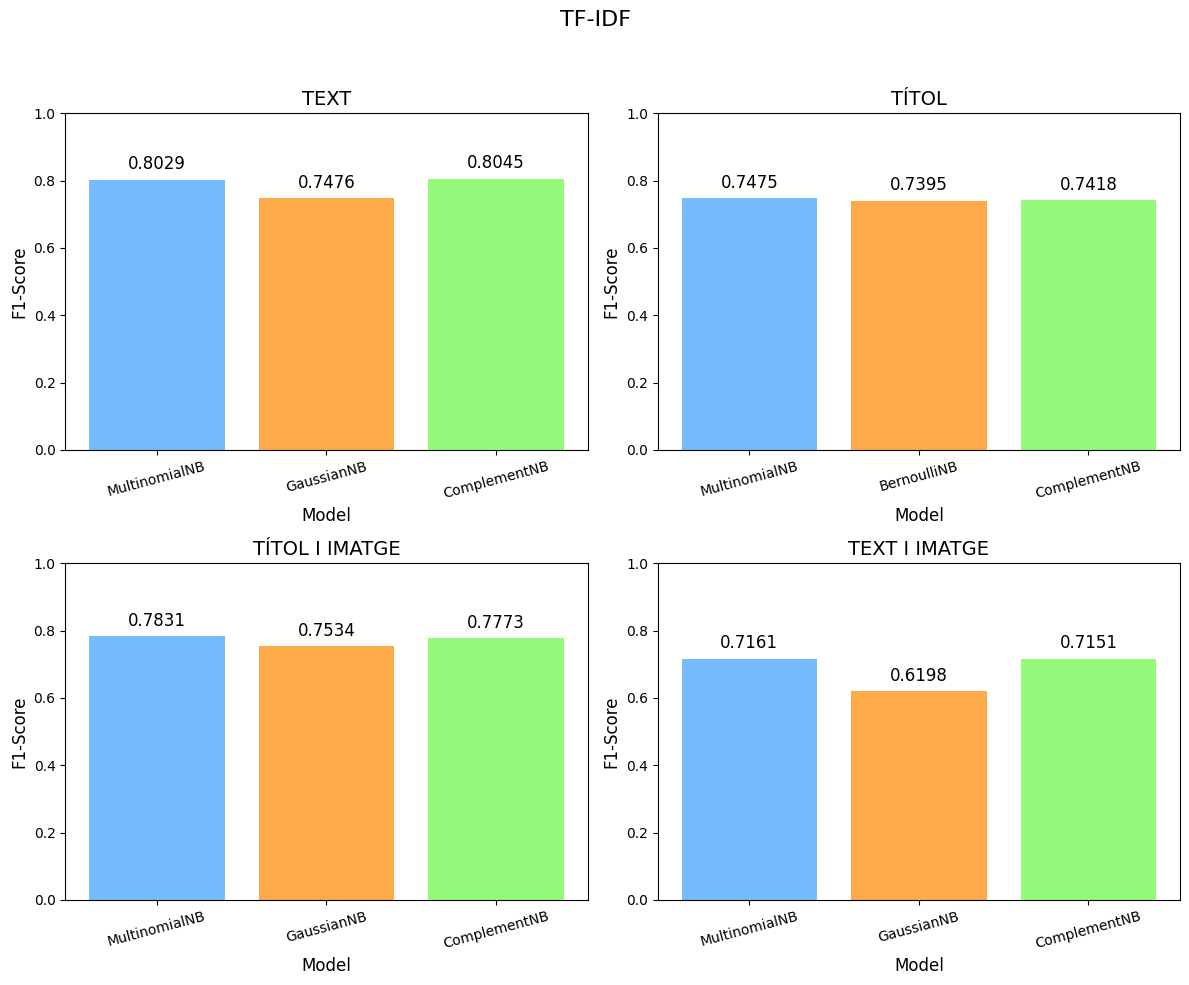

In [691]:
configs = [
    (["MultinomialNB", "GaussianNB","ComplementNB"], [grid_multinomial5.best_score_, grid_gaussian5.best_score_,grid_complement5.best_score_ ], "TEXT"),
    (["MultinomialNB", "BernoulliNB","ComplementNB"], [grid_multinomial6.best_score_,grid_bernoulli6.best_score_, grid_complement6.best_score_ ], "TÍTOL"),
    (["MultinomialNB","GaussianNB", "ComplementNB"], [grid_multinomial7.best_score_,grid_gaussian7.best_score_, grid_complement7.best_score_ ], "TÍTOL I IMATGE"),
    (["MultinomialNB", "GaussianNB","ComplementNB"], [grid_multinomial8.best_score_,grid_gaussian8.best_score_, grid_complement8.best_score_  ], "TEXT I IMATGE"),
    (["MultinomialNB", "ComplementNB"], [grid_multinomial.best_score_, grid_complement.best_score_ ], "TÍTOL I AUTOR"),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("TF-IDF", fontsize=16)

for ax, (models, scores, title) in zip(axes.flatten(), configs):
    bars = ax.bar(models, scores, color=['xkcd:sky blue', 'xkcd:light orange', 'xkcd:light green', 'xkcd:salmon'][:len(models)])
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("F1-Score", fontsize=12)
    ax.tick_params(axis='x', rotation=15)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


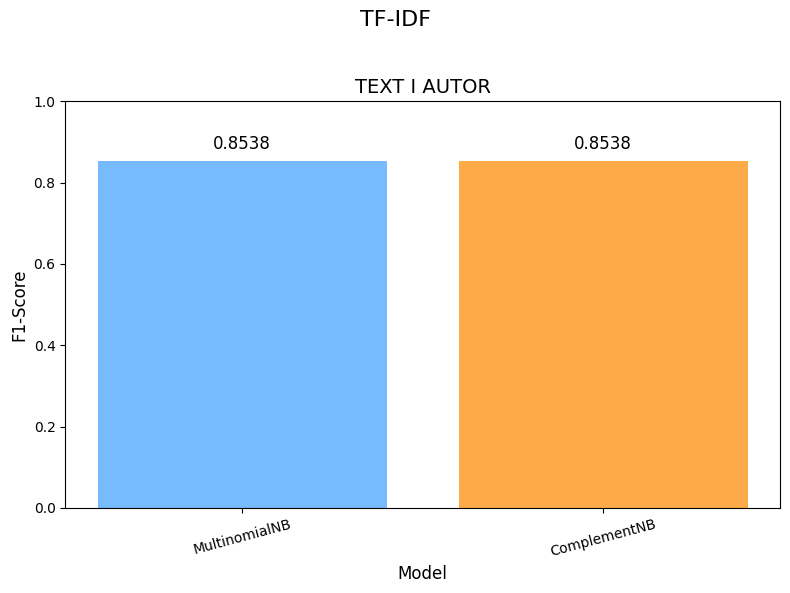

In [692]:
configs = [
    (["MultinomialNB", "ComplementNB"], [grid_multinomial.best_score_, grid_complement.best_score_], "TEXT I AUTOR"),
]

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle("TF-IDF", fontsize=16)

bars = axes.bar(configs[0][0], configs[0][1], color=['xkcd:sky blue', 'xkcd:light orange'])
axes.set_ylim(0, 1)
axes.set_title(configs[0][2], fontsize=14)
axes.set_xlabel("Model", fontsize=12)
axes.set_ylabel("F1-Score", fontsize=12)
axes.tick_params(axis='x', rotation=15)

for bar in bars:
    yval = bar.get_height()
    axes.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# ANÀLISI FINAL

Els millor resultats els obtenim una vegada afegit el autor, però podem veure que no és consistent ja que en el nostre dataset hi ha molts no authors o activistes sense nom o anonims, per tant no el trobem una característica representativa. A més, els autors que no són desconeguts no contribueixen a que el model sigui més bo generalitzant.

Per tant aquests els descartem i ens quedem com el millor model aquell que utilitza el mètode TF-IDF i considera només el text. Pel que fa al mètode de classificació hi ha dos models que donen alt en aquest cas, el MultinomialNB i el ComplementNB. Per poc, el millor és el ComplementNB.

In [693]:
nb = ComplementNB(alpha=2.5, norm=True) 
nb.fit(X_train5, y_train5)    


ComplementNB(alpha=2.5, norm=True)

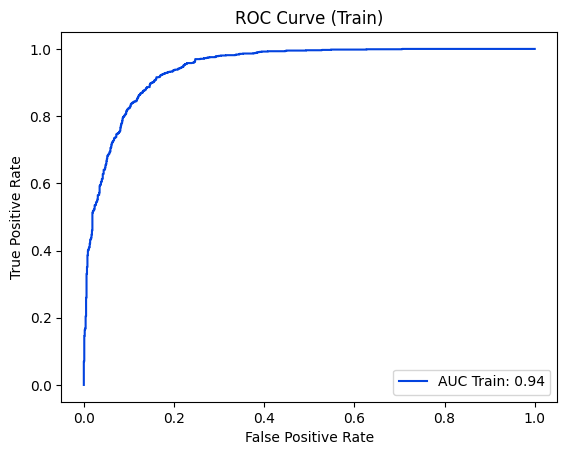

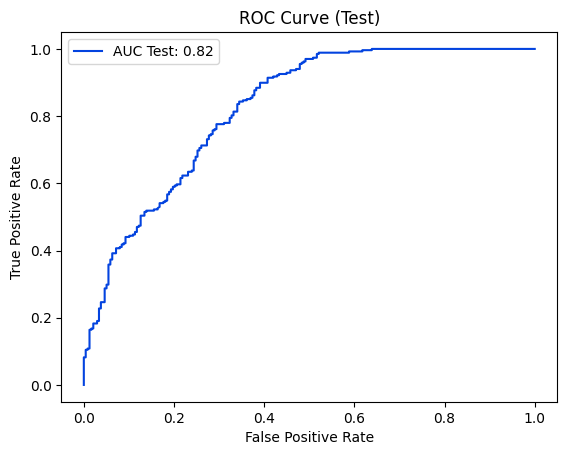

In [694]:
from sklearn.metrics import roc_curve,roc_auc_score

# Corba ROC
probs = nb.predict_proba(X_train5)
probs_test = nb.predict_proba(X_test5)

fpr, tpr, _ = roc_curve(y_train5, probs[:, 1])
roc_auc = roc_auc_score(y_train5, probs[:, 1])

fpr_test, tpr_test, _ = roc_curve(y_test5, probs_test[:, 1])
roc_auc_test = roc_auc_score(y_test5, probs_test[:, 1])

plt.plot(fpr, tpr, color='xkcd:blue', label=f'AUC Train: {round(roc_auc, 2)}')
plt.title('ROC Curve (Train)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

plt.plot(fpr_test, tpr_test, color='xkcd:blue', label=f'AUC Test: {round(roc_auc_test, 2)}')
plt.title('ROC Curve (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [695]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = nb.predict(X_test5)
accuracy = accuracy_score(y_test5, y_pred)
print(f'Accuracy: {accuracy:.2f}')

f1 = f1_score(y_test5, y_pred)

print(f'F1 Score: {f1:.2f}')

Accuracy: 0.75
F1 Score: 0.78


[[156  82]
 [ 42 226]]
[0.78787879 0.73376623] [0.65546218 0.84328358] [0.71559633 0.78472222] [238 268]


Text(50.722222222222214, 0.5, 'Classe Real')

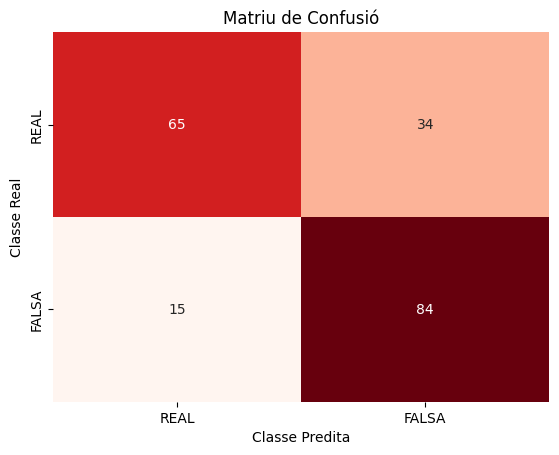

In [696]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

conf = confusion_matrix(y_test5,y_pred)

prec,rec,f1, sup = precision_recall_fscore_support(y_test5,y_pred)
print(conf)
print(prec, rec, f1, sup)

conf_perc=np.array(100*conf.T/conf.sum(axis = 1),dtype = int).T
sns.heatmap(conf_perc, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=['REAL', 'FALSA'], yticklabels=['REAL', 'FALSA'])

plt.title('Matriu de Confusió')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')

# CAS D'ÚS

In [697]:
from newspaper import Article
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_without_stopwords'])

y = df['label']
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

nb = ComplementNB(alpha=2.5, norm=True) 
nb.fit(X_train5, y_train5)  

def obtenir_contingut(link):
    try:
        article = Article(link)
        article.download()
        article.parse()
        return article.text
    except Exception as e:
        print(f"Error al processar l'enllaç {link}: {e}")
        return None

def eliminar_stopwords(text):
    stop_words = set(stopwords.words('english'))
    paraules = text.split()
    text_sense_stopwords = " ".join([paraula for paraula in paraules if paraula.lower() not in stop_words])
    return text_sense_stopwords

noticies_links = [
    "https://www.bbc.com/news/articles/c62l5zdv7zko",  #enllaç de notícia real
    "https://theonion.com/nations-mumblers-march-on-washington-demanding-something-or-other/"  #enllaç de notícia falsa
]

# Obtenir i processar els textos de les notícies
noticies_textos = [obtenir_contingut(link) for link in noticies_links]
noticies_textos = [text for text in noticies_textos if text]
noticies_textos_sense_stopwords = [eliminar_stopwords(text) for text in noticies_textos]

if len(noticies_textos_sense_stopwords) == 0:
    print("No s'han obtingut textos vàlids per a la vectorització.")
else:
    noticies_tfidf = tfidf_vectorizer.transform(noticies_textos_sense_stopwords)
    prediccions = nb.predict(noticies_tfidf)
    
    etiquetes = {0: "Verídica", 1: "Falsa"}
    for i, link in enumerate(noticies_links):
        print(f"Enllaç: {link}")
        if i < len(prediccions):
            print(f"Predicció: {etiquetes[prediccions[i]]}")
        else:
            print("Predicció: No hi ha predicció disponible")
        print("-" * 50)


Enllaç: https://www.bbc.com/news/articles/c62l5zdv7zko
Predicció: Verídica
--------------------------------------------------
Enllaç: https://theonion.com/nations-mumblers-march-on-washington-demanding-something-or-other/
Predicció: Falsa
--------------------------------------------------
